### Imports

In [1]:
import cv2
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Useful Functions

In [2]:
# Clears alpha channel from png images
def clearAlphaChannel(img):
    trans_mask = img[:,:,3] == 0
    img[trans_mask] = [255, 255, 255, 255]
    new_img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    return new_img

In [3]:
# Splits a list of couple in 2 different list and append in both list in result
def splitCouple(coupleList):
    result = []
    for couple in coupleList:
        fstList, sndList = list(map(list, zip(*couple)))
        result.append(fstList)
        result.append(sndList)
    return result

In [4]:
# Returns area of a rectangle object
def getArea(rectangle):
    return rectangle[4]

In [5]:
# Binary split of the gray image
def thresholding(img):
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_gray,80,255,cv2.THRESH_BINARY_INV)
    return thresh

In [6]:
# Resize image 
def imgResize(img, size):
    imgResult = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, c = imgResult.shape
    if w > size:
        new_w = 1000
        ar = w/h
        new_h = int(new_w/ar)
        imgResult = cv2.resize(imgResult, (new_w, new_h), interpolation = cv2.INTER_AREA)
    return imgResult

In [7]:
def lineSegmentation(img):
    kernel = np.ones((3,85), np.uint8)
    dilated = cv2.dilate(thresholding(img), kernel, iterations = 1)
    (contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    lineCount = 0
    for ctr in sorted_contours_lines:
        x,y,w,h = cv2.boundingRect(ctr)
        cv2.rectangle(img, (x,y), (x+w, y+h), (40, 100, 250), 2)
        lineCount += 1
    return lineCount

In [14]:
def lineSegmentationAndSave(img, session):
    kernel = np.ones((3,85), np.uint8)
    dilated = cv2.dilate(thresholding(img), kernel, iterations = 1)
    (contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    lineCount = 0
    for ctr in sorted_contours_lines:
        x,y,w,h = cv2.boundingRect(ctr)
        cv2.rectangle(img, (x,y), (x+w, y+h), (255, 255, 255), 2)
        roi = img[y:y+h, x:x+w]
        cv2.imwrite("Lines/Session" + str(session) + "Line" +  str(lineCount) + ".png", roi)
        lineCount += 1

In [9]:
def textSegmentation(img, session, df):
    result = pd.DataFrame(columns=['Session','Line','wordAx','wordAy','wordBx','wordBy'])
    words_list = []
    box_list = []
    lineNumber = 1
    kernel = np.ones((3,85), np.uint8)
    dilated = cv2.dilate(thresholding(img), kernel, iterations = 1)
    (contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)

    kernel = np.ones((3,15), np.uint8)
    dilated = cv2.dilate(thresholding(img), kernel, iterations = 1)

    for line in sorted_contours_lines:
        # roi of each line
        x, y, w, h = cv2.boundingRect(line)
        roi_line = dilated[y:y+w, x:x+w]
        # draw contours on each word
        (cnt, heirarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        sorted_contour_words = sorted(cnt, key=lambda cntr : cv2.boundingRect(cntr)[0])
        for word in sorted_contour_words:
            x2, y2, w2, h2 = cv2.boundingRect(word)
            if w2*h2 > 500 and [x+x2, y+y2, x+x2+w2, y+y2+h2, w2*h2, lineNumber, y] not in words_list and y+y2>=y and y+y2+h2<=y+h:
                words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2, w2*h2, lineNumber, y])
        lineNumber += 1

    words_list.sort(key=getArea, reverse=True)
    for word in words_list:
        overlap = 1
        for new_word in words_list:
            if word[0]>=new_word[0] and word[1]>=new_word[1] and word[2]<=new_word[2] and word[3]<=new_word[3] and word[4]!=new_word[4]:
                overlap = 0
                break
        if overlap:
            box_list.append(word)
            data = pd.DataFrame({'Session':session,'Line':word[5], 'wordAx':word[0],'wordAy':word[1],'wordBx':word[2],'wordBy':word[3]}, index=[0])
            result = pd.concat([result, data], ignore_index=True)    

    for word in box_list:
        if word[5]==1:
            cv2.rectangle(img, (word[0], word[1]), (word[2],word[3]), (255,0,0), 2)
        if word[5]==2:
            cv2.rectangle(img, (word[0], word[1]), (word[2],word[3]), (0,255,0), 2)
        if word[5]==3:
            cv2.rectangle(img, (word[0], word[1]), (word[2],word[3]), (0,0,255), 2)
        if word[5]==4:
            cv2.rectangle(img, (word[0], word[1]), (word[2],word[3]), (255,0,255), 2)
        if word[5]==5:
            cv2.rectangle(img, (word[0], word[1]), (word[2],word[3]), (255,255,0), 2)
        if word[5]==6:
            cv2.rectangle(img, (word[0], word[1]), (word[2],word[3]), (0,255,255), 2)
        if word[5]==7:
            cv2.rectangle(img, (word[0], word[1]), (word[2],word[3]), (127,0,127), 2)
        if word[5]==8:
            cv2.rectangle(img, (word[0], word[1]), (word[2],word[3]), (0,127,127), 2)

    df[result.columns] = result
    return len(box_list)

In [10]:
def extractLineFeature(session, height, width, posX, posY, interX, interY, overlap, df):
    dfs = df.loc[df['Session'] == session]
    posXList = [] #solo per il primo box della linea, quindi valore unico per Linea
    interSpaceYList=[]
    for line in range(1, 9):
        dfl = dfs.loc[dfs['Line'] == line]
        heightList=[]
        widthList=[]
        posYList=[]
        interCoupleX=[]
        interSpaceX=[]
        interCoupleY=[]
        overlapCheck=0
        interA=0
        interB=0
        for ind in dfl.index:
            heightList.append(dfl['wordBy'][ind]-dfl['wordAy'][ind])
            widthList.append(dfl['wordBx'][ind]-dfl['wordAx'][ind])
            posYList.append(dfl['wordAy'][ind])
            posXList.append(dfl['wordAx'][ind])
            interCoupleX.append([dfl['wordAx'][ind],dfl['wordBx'][ind]])
            interCoupleY.append([dfl['wordAy'][ind],dfl['wordBy'][ind]])
#Height
        meanHeight=statistics.mean(heightList)
        stdHeight=np.std(heightList)
#Width
        meanWidth=statistics.mean(widthList)
        stdWidth=np.std(widthList)
#PosY(Andamento Linea)
        meanPosY=statistics.mean(posYList)
        stdPosY=np.std(posYList)

#InterSpaceX
        meanInterSpaceX = 0
        stdInterSpaceX = 0
        if len(interCoupleX)>1:
                interCoupleX.sort()
                for i in range(len(interCoupleX)-1):
                        interSpaceX.append(interCoupleX[i+1][0]-interCoupleX[i][1])
                        if interCoupleX[i+1][0]<interCoupleX[i][1]:
                                overlapCheck=1
                meanInterSpaceX=statistics.mean(interSpaceX)
                stdInterSpaceX=np.std(interSpaceX)

#PosX(posizione iniziale da dove inizio a scrivere sul asse X)
        minPosX=min(posXList)

#InterSpaceY(Distanza tra linee in altezza)
        listA, listB = list(map(list, zip(*interCoupleY)))
        interA=min(listA)
        interB=max(listB)

#Inserimento nelle liste
        height[line-1].append((meanHeight, stdHeight))
        width[line-1].append((meanWidth, stdWidth))
        posY[line-1].append((meanPosY, stdPosY))
        interX[line-1].append((meanInterSpaceX, stdInterSpaceX))
        overlap[line-1].append(overlapCheck)
        posXList.append(minPosX)
        interSpaceYList.append((interA,interB))

    meanPosX=statistics.mean(posXList)
    stdPosX=np.std(posXList)

    interSpaceY=[]
    for i in range(len(interSpaceYList)-1):
            interSpaceY.append(interSpaceYList[i+1][1]-interSpaceYList[i][0])
    meanInterY=statistics.mean(interSpaceY)
    stdInterY=np.std(interSpaceY)

    posX.append((meanPosX, stdPosX))
    interY.append((meanInterY, stdInterY))

In [11]:
def addLineFeature(heigth, width, posX, posY, interX, interY, overlap, df):
    wordHeightFeature = splitCouple(height)
    wordWidthFeature = splitCouple(width)
    yLineTrendFeature = splitCouple(posY)
    wordDistanceFeature = splitCouple(interX)
    for i in range(2, 17, 2):
        df["meanWordHeightLine" + str(int(i/2))] = wordHeightFeature[i-2]
        df["stdWordHeightLine" +str(int(i/2))] = wordHeightFeature[i-1]
        df["meanWordWidthLine" + str(int(i/2))] = wordWidthFeature[i-2]
        df["stdWordWidthLine" +str(int(i/2))] = wordWidthFeature[i-1]
        df["meanYLineTrendLine" + str(int(i/2))] = yLineTrendFeature[i-2]
        df["stdYLineTrendLine" +str(int(i/2))] = yLineTrendFeature[i-1]
        df["meanWordDistanceLine" + str(int(i/2))] = wordDistanceFeature[i-2]
        df["stdWordDistanceLine" +str(int(i/2))] = wordDistanceFeature[i-1]

    for i in range(1, 9):
        df["overlappedWordLine" + str(i)] = overlap[i-1]

    meanPosXLineStart, stdPosXLineStart = list(map(list, zip(*posX)))
    df["meanPosXLineStart"] = meanPosXLineStart
    df["stdPosXLineStart"] = stdPosXLineStart

    meanLineDistance, stdLineDistance = list(map(list, zip(*interY)))
    df["meanLineDistance"] = meanLineDistance
    df["stdLineDistance"] = stdLineDistance

In [12]:
def imageTranslation(session, folderName, hDirection, vDirection):
    img = cv2.imread("Paintings/row" + str(session) + ".png", cv2.IMREAD_UNCHANGED)
    img = clearAlphaChannel(img)
    img = imgResize(img, 1000)
        
    height, width = img.shape[:2]

    T = np.float32([[1, 0, hDirection], [0, 1, vDirection]])

    img_translation = cv2.warpAffine(img, T, (width, height), borderValue=(255,255,255))
        
    cv2.imwrite("TranslatedPaintings/" + folderName + "/row" + str(session) + ".png", img_translation)

## Image Preprocess

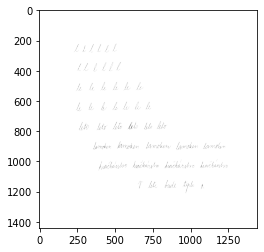

In [12]:
img = cv2.imread("Paintings/row0.png", cv2.IMREAD_UNCHANGED)
plt.imshow(img)

#### 1 - Clear alpha channel from the image

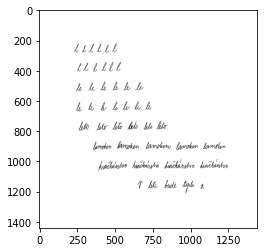

In [13]:
img = clearAlphaChannel(img)
plt.imshow(img)

#### 2 - Resizing image

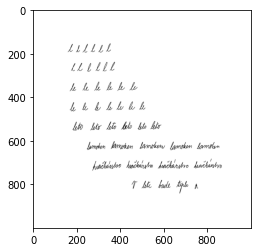

In [14]:
img = imgResize(img, 1000)
plt.imshow(img)

#### 3 - Line segmentation

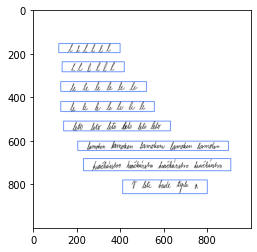

In [15]:
img2 = img.copy()
lineSegmentation(img2)   
plt.imshow(img2)

#### 4 - Text segmentation

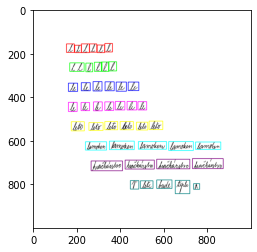

In [16]:
prova = pd.DataFrame(columns=['Session','Line','wordAx','wordAy','wordBx','wordBy'])

img3 = img.copy()
textSegmentation(img3, 0, prova)   
plt.imshow(img3)

  ## Preprocessing all images in the dataset

In [17]:
 # Df to store every words in the dataset
words_df = pd.DataFrame(columns=['Session','Line','wordAx','wordAy','wordBx','wordBy'])

sessionLines  = []
sessionWords = []

#Final Features
height = [[], [], [], [], [], [], [], []]
width = [[], [], [], [], [], [], [], []]
posX = []
posY = [[], [], [], [], [], [], [], []]
interX = [[], [], [], [], [], [], [], []]
interY = []
overlap = [[], [], [], [], [], [], [], []]

for i in range(120):
    img = cv2.imread("Paintings/row" + str(i) + ".png", cv2.IMREAD_UNCHANGED)
    img = clearAlphaChannel(img)
    img = imgResize(img, 1000)
    img2 = img.copy()
    sessionLines.append(lineSegmentation(img2))
    img3 = img.copy()
    sessionWords.append(textSegmentation(img3, i, words_df))
    extractLineFeature(i, height, width, posX, posY, interX, interY, overlap, words_df)

# Save updated dataset
words_df.to_csv('WordsDatasets/wordsDataset.csv', index=False)

  ## Saving boxed images

In [16]:
for i in range(120):
    img = cv2.imread("Paintings/row" + str(i) + ".png", cv2.IMREAD_UNCHANGED)
    img = clearAlphaChannel(img)
    img = imgResize(img, 1000)
    img2 = img.copy()
    lineSegmentationAndSave(img2, i)


## OpenCV dataset

In [18]:
openCV_df = pd.DataFrame()

##### N. of lines and words (for each session) are the first two feature added in the df

In [19]:
openCV_df["lines"] = sessionLines
openCV_df["words"] = sessionWords
openCV_df

,lines,words
0,8,44
1,8,38
2,8,39
3,8,32
4,8,38
...,...,...
115,8,27
116,8,35
117,8,38
118,8,41


#### Adding line features previously found

In [20]:
addLineFeature(height, width, posX, posY, interX, interY, overlap, openCV_df)
openCV_df

,lines,words,meanWordHeightLine1,stdWordHeightLine1,meanWordWidthLine1,stdWordWidthLine1,meanYLineTrendLine1,stdYLineTrendLine1,meanWordDistanceLine1,stdWordDistanceLine1,...,overlappedWordLine3,overlappedWordLine4,overlappedWordLine5,overlappedWordLine6,overlappedWordLine7,overlappedWordLine8,meanPosXLineStart,stdPosXLineStart,meanLineDistance,stdLineDistance
0,8,44,37.500000,2.217356,34.333333,1.972027,156.500000,2.929733,1.0,1.095445,...,0,0,0,0,0,0,338.211538,167.983554,138.571429,9.393876
1,8,38,35.166667,4.669642,41.833333,10.122856,158.333333,3.299832,-0.6,3.261901,...,0,0,0,0,0,0,316.869565,163.493732,132.428571,3.539860
2,8,39,36.500000,2.291288,38.833333,2.910708,154.666667,1.699673,15.4,5.276362,...,0,0,0,0,0,1,350.446809,171.881801,142.571429,13.318699
3,8,32,47.166667,3.387067,41.500000,7.973916,158.500000,3.593976,0.0,2.828427,...,0,1,1,0,0,1,284.725000,144.690357,153.714286,9.315337
4,8,38,34.333333,3.349959,36.333333,5.249339,157.500000,2.629956,25.4,14.388885,...,0,0,0,0,0,1,335.543478,164.942507,136.000000,8.159132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,8,27,38.333333,6.018490,76.000000,30.210373,161.333333,7.408704,-5.0,1.000000,...,1,1,1,1,1,1,294.314286,152.228545,141.285714,5.256677
116,8,35,32.666667,2.357023,33.333333,3.399346,155.666667,1.490712,8.8,4.621688,...,0,0,0,0,0,0,303.674419,149.368706,129.714286,3.057276
117,8,38,30.833333,1.771691,27.833333,2.034426,155.500000,1.892969,8.2,5.306600,...,0,0,0,0,0,0,306.586957,158.727491,127.000000,3.964125
118,8,41,38.000000,2.645751,33.666667,2.211083,158.000000,2.380476,14.8,3.709447,...,0,0,0,0,0,1,327.285714,161.471676,133.714286,2.249717


In [21]:
openCV_df.to_csv('OpenCVDatasets/openCVDataset.csv', index=False)

## Data augmentation

#### Translating images to create new datas

In [22]:
for i in range(120):
    imageTranslation(i, "UpRight", 50, -50)
    imageTranslation(i, "UpLeft", -50, -50)
    imageTranslation(i, "DownRight", 50, 50)
    imageTranslation(i, "DownLeft", -50, 50)

### Preprocessing and feature extraction from translated images

#### UpLeft translation

In [23]:
 # Df to store every words in the dataset
words_df = pd.DataFrame(columns=['Session','Line','wordAx','wordAy','wordBx','wordBy'])

sessionLines  = []
sessionWords = []

#Final Features
height = [[], [], [], [], [], [], [], []]
width = [[], [], [], [], [], [], [], []]
posX = []
posY = [[], [], [], [], [], [], [], []]
interX = [[], [], [], [], [], [], [], []]
interY = []
overlap = [[], [], [], [], [], [], [], []]

for i in range(120):
    img = cv2.imread("TranslatedPaintings/UpLeft/row" + str(i) + ".png")
    img2 = img.copy()
    sessionLines.append(lineSegmentation(img2))
    img3 = img.copy()
    sessionWords.append(textSegmentation(img3, i, words_df))
    extractLineFeature(i, height, width, posX, posY, interX, interY, overlap, words_df)

# Save updated dataset
words_df.to_csv('WordsDatasets/wordsDatasetUpLeft.csv', index=False)

In [24]:
openCV_df = pd.DataFrame()
openCV_df["lines"] = sessionLines
openCV_df["words"] = sessionWords
addLineFeature(height, width, posX, posY, interX, interY, overlap, openCV_df)
openCV_df.to_csv('OpenCVDatasets/openCVDatasetUpLeft.csv', index=False)

#### UpRight translation

In [25]:
 # Df to store every words in the dataset
words_df = pd.DataFrame(columns=['Session','Line','wordAx','wordAy','wordBx','wordBy'])

sessionLines  = []
sessionWords = []

#Final Features
height = [[], [], [], [], [], [], [], []]
width = [[], [], [], [], [], [], [], []]
posX = []
posY = [[], [], [], [], [], [], [], []]
interX = [[], [], [], [], [], [], [], []]
interY = []
overlap = [[], [], [], [], [], [], [], []]

for i in range(120):
    img = cv2.imread("TranslatedPaintings/UpRight/row" + str(i) + ".png")
    img2 = img.copy()
    sessionLines.append(lineSegmentation(img2))
    img3 = img.copy()
    sessionWords.append(textSegmentation(img3, i, words_df))
    extractLineFeature(i, height, width, posX, posY, interX, interY, overlap, words_df)

# Save updated dataset
words_df.to_csv('WordsDatasets/wordsDatasetUpRight.csv', index=False)

In [26]:
openCV_df = pd.DataFrame()
openCV_df["lines"] = sessionLines
openCV_df["words"] = sessionWords
addLineFeature(height, width, posX, posY, interX, interY, overlap, openCV_df)
openCV_df.to_csv('OpenCVDatasets/openCVDatasetUpRight.csv', index=False)

#### DownLeft translation

In [27]:
 # Df to store every words in the dataset
words_df = pd.DataFrame(columns=['Session','Line','wordAx','wordAy','wordBx','wordBy'])

sessionLines  = []
sessionWords = []

#Final Features
height = [[], [], [], [], [], [], [], []]
width = [[], [], [], [], [], [], [], []]
posX = []
posY = [[], [], [], [], [], [], [], []]
interX = [[], [], [], [], [], [], [], []]
interY = []
overlap = [[], [], [], [], [], [], [], []]

for i in range(120):
    img = cv2.imread("TranslatedPaintings/DownLeft/row" + str(i) + ".png")
    img2 = img.copy()
    sessionLines.append(lineSegmentation(img2))
    img3 = img.copy()
    sessionWords.append(textSegmentation(img3, i, words_df))
    extractLineFeature(i, height, width, posX, posY, interX, interY, overlap, words_df)

# Save updated dataset
words_df.to_csv('WordsDatasets/wordsDatasetDownLeft.csv', index=False)

In [28]:
openCV_df = pd.DataFrame()
openCV_df["lines"] = sessionLines
openCV_df["words"] = sessionWords
addLineFeature(height, width, posX, posY, interX, interY, overlap, openCV_df)
openCV_df.to_csv('OpenCVDatasets/openCVDatasetDownLeft.csv', index=False)

#### DownRight translation

In [29]:
 # Df to store every words in the dataset
words_df = pd.DataFrame(columns=['Session','Line','wordAx','wordAy','wordBx','wordBy'])

sessionLines  = []
sessionWords = []

#Final Features
height = [[], [], [], [], [], [], [], []]
width = [[], [], [], [], [], [], [], []]
posX = []
posY = [[], [], [], [], [], [], [], []]
interX = [[], [], [], [], [], [], [], []]
interY = []
overlap = [[], [], [], [], [], [], [], []]

for i in range(120):
    img = cv2.imread("TranslatedPaintings/DownRight/row" + str(i) + ".png")
    img2 = img.copy()
    sessionLines.append(lineSegmentation(img2))
    img3 = img.copy()
    sessionWords.append(textSegmentation(img3, i, words_df))
    extractLineFeature(i, height, width, posX, posY, interX, interY, overlap, words_df)

# Save updated dataset
words_df.to_csv('WordsDatasets/wordsDatasetDownRight.csv', index=False)

In [30]:
openCV_df = pd.DataFrame()
openCV_df["lines"] = sessionLines
openCV_df["words"] = sessionWords
addLineFeature(height, width, posX, posY, interX, interY, overlap, openCV_df)
openCV_df.to_csv('OpenCVDatasets/openCVDatasetDownRight.csv', index=False)